#Testing Model Calibration

In [1]:
#todo:
#Scale features for some classifiers
#automate ensemble
#Boruta
#Add classifiers (non-linear SVM)

In [28]:
%matplotlib inline

#Import necessary packages
import psycopg2
import sys  

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from config import REDSHIFT_CONFIG
from src.features import *
from src.utils import *
from src.validation import *

reload(sys)
sys.setdefaultencoding('utf8')

from src.exploration import *

In [3]:
# Establish a connection to the redshift database
conn = create_rs_conn(config=REDSHIFT_CONFIG)
cur = conn.cursor()

## Creating data sets for Verlander from both the original pitch data and the rule-based reclassification provided by Alan. Then, going to run through some modeling with them and compare the accuracy differences 

In [6]:
#Going to run through these steps with the real verlander and reclassed verlander data side by side
verlander_df = get_pitcher_df_for_modeling(cur, pitcher_id = 434378, date_subsetting = False)
verlander_df_rc = get_pitcher_df_for_modeling(cur, pitcher_id = 434378, date_subsetting = False, table = 'all_pitch_data_reclass')

In [7]:
#Subset the dates to get rid of weird data before 2009 and partial season data in 2015
verlander_df = verlander_df[(verlander_df['date'] >= '2009-01-01') &
                            (verlander_df['date'] <= '2015-01-01')]
verlander_df_rc = verlander_df_rc[(verlander_df_rc['date'] >= '2009-01-01') &
                            (verlander_df_rc['date'] <= '2015-01-01')]

###Check out the binarized breakdown of pitch types by year for the original and reclassified pitches

In [8]:
get_pitch_types_by_year(verlander_df, use_gameday=False)

pitch_type,Fastball,Not_Fastball
2009,2633,1285
2010,2187,1551
2011,2456,1811
2012,2303,1829
2013,2225,1704
2014,1936,1574


In [9]:
#Same totals but different fractions of each pitch
get_pitch_types_by_year(verlander_df_rc, use_gameday=False)

pitch_type,Fastball,Not_Fastball
2009,2568,1350
2010,2300,1438
2011,2421,1846
2012,2386,1746
2013,2192,1737
2014,1933,1577


### Splitting the data half-way through the 2014 season and then checking to make sure the two data sets are identical in terms of number of observations

In [10]:
modeling_data = split_test_train(verlander_df, '2014-06-01')
modeling_data_rc = split_test_train(verlander_df_rc, '2014-06-01')

In [11]:
len(modeling_data['train_data'])

21332

In [12]:
len(modeling_data['train_data']) == len(modeling_data_rc['train_data'])

True

In [13]:
len(modeling_data['test_data'])

2162

In [14]:
len(modeling_data['test_data'])  == len(modeling_data_rc['test_data']) 

True

In [15]:
#Increase the number of columns displayed with Pandas
pd.set_option('display.max_columns', 500)

### Importing libraries needed to run a Random Forest and evaluate the accuracy

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score

Function to Subset the data down to contain only certain columns

In [17]:
def subset_data(modeling_dict, cols_of_interest):
    new_dict = modeling_dict.copy()
    new_dict['train_data'] = new_dict['train_data'][cols_of_interest]
    new_dict['test_data'] = new_dict['test_data'][cols_of_interest]
    return new_dict

Check out the columns for potential subsetting

In [18]:
modeling_data['train_data'].columns

Index([u'b', u's', u'on_1b', u'on_2b', u'on_3b', u'o', u'home_wins',
       u'home_loss', u'away_wins', u'away_loss', u'Not_Fastball_pb_prior',
       u'Not_Fastball_pbs_prior', u'Fastball_pb_prior', u'Fastball_pbs_prior',
       u'Not_Fastball_pc_prior', u'Not_Fastball_pcs_prior',
       u'Fastball_pc_prior', u'Fastball_pcs_prior', u'Not_Fastball_pg_prior',
       u'Not_Fastball_pgs_prior', u'Fastball_pg_prior', u'Fastball_pgs_prior',
       u'score_diff', u'ingame_pitch_count', u'season_pitch_count',
       u'prev_pitches_mean_start_speed', u'prev_pitches_mean_end_speed',
       u'prev_pitches_mean_break_y', u'prev_pitches_mean_break_angle',
       u'prev_pitches_mean_break_length', u'cur_season', u'stand_L',
       u'stand_R', u'p_throws_R', u'stadium_name_AT&T Park',
       u'stadium_name_Angel Stadium of Anaheim', u'stadium_name_Busch Stadium',
       u'stadium_name_Chase Field', u'stadium_name_Citi Field',
       u'stadium_name_Comerica Park', u'stadium_name_Coors Field',
       

Create different potential column subset groups

In [19]:
#Basic features
the_basics = [u'b', u's', u'on_1b', u'on_2b', u'on_3b', u'o', 
              u'home_wins',u'home_loss', u'away_wins', u'away_loss', 
              u'stand_L', u'stand_R', u'p_throws_R']

#Adding previous batter priors
with_pbs_priors = the_basics + [u'Not_Fastball_pb_prior',
                                u'Not_Fastball_pbs_prior', u'Fastball_pb_prior', u'Fastball_pbs_prior']

#Adding pc priors
with_pc_priors = the_basics + [u'Not_Fastball_pc_prior', u'Not_Fastball_pcs_prior',
                               u'Fastball_pc_prior', u'Fastball_pcs_prior']

#Adding previous games priors
with_pg_priors = the_basics + [u'Not_Fastball_pg_prior', u'Not_Fastball_pgs_prior', 
                               u'Fastball_pg_prior', u'Fastball_pgs_prior']

#Adding all priors
basics_and_priors = (the_basics + [u'Not_Fastball_pb_prior',
                                u'Not_Fastball_pbs_prior', u'Fastball_pb_prior', u'Fastball_pbs_prior'] +
                     [u'Not_Fastball_pc_prior', u'Not_Fastball_pcs_prior',
                               u'Fastball_pc_prior', u'Fastball_pcs_prior'] + 
                    [u'Not_Fastball_pg_prior', u'Not_Fastball_pgs_prior', 
                               u'Fastball_pg_prior', u'Fastball_pgs_prior'])

#Adding previous pitch info
with_previous_pitch_info = the_basics + [u'last_pitch_type_Fastball', u'last_pitch_type_Not_Fastball',
       u'last_pitch_type_not_available', u'second_last_pitch_type_Fastball',
       u'second_last_pitch_type_Not_Fastball',
       u'second_last_pitch_type_not_available',
       u'third_last_pitch_type_Fastball',
       u'third_last_pitch_type_Not_Fastball',
       u'third_last_pitch_type_not_available', u'prev_pitches_mean_start_speed', u'prev_pitches_mean_end_speed',
       u'prev_pitches_mean_break_y', u'prev_pitches_mean_break_angle',
       u'prev_pitches_mean_break_length']

#priors and previous pitch info
basics_priors_prev = basics_and_priors + [u'last_pitch_type_Fastball', u'last_pitch_type_Not_Fastball',
       u'last_pitch_type_not_available', u'second_last_pitch_type_Fastball',
       u'second_last_pitch_type_Not_Fastball',
       u'second_last_pitch_type_not_available',
       u'third_last_pitch_type_Fastball',
       u'third_last_pitch_type_Not_Fastball',
       u'third_last_pitch_type_not_available', u'prev_pitches_mean_start_speed', u'prev_pitches_mean_end_speed',
       u'prev_pitches_mean_break_y', u'prev_pitches_mean_break_angle',
       u'prev_pitches_mean_break_length']

#Adding pitch_counts and previous pitches speeds and breaks
with_pitch_counts_speeds_breaks = the_basics + [u'ingame_pitch_count', u'cur_season', 
                                                u'season_pitch_count']

#Combining it with the above
basics_pitch_stats_prev = basics_priors_prev + [u'ingame_pitch_count', u'cur_season', u'season_pitch_count']

#Everything previous with stadiums Stadiums (should be all variables
with_stadiums = basics_pitch_stats_prev + [u'stadium_name_Angel Stadium of Anaheim',
       u'stadium_name_Citi Field', u'stadium_name_Comerica Park',
       u'stadium_name_Fenway Park', u'stadium_name_Great American Ball Park',
       u'stadium_name_Hubert H. Humphrey Metrodome',
       u'stadium_name_Kauffman Stadium', u'stadium_name_Minute Maid Park',
       u'stadium_name_Oakland Coliseum',
       u'stadium_name_Oriole Park at Camden Yards', u'stadium_name_PNC Park',
       u'stadium_name_Progressive Field',
       u'stadium_name_Rangers Ballpark in Arlington',
       u'stadium_name_Rogers Centre', u'stadium_name_Safeco Field',
       u'stadium_name_Target Field', u'stadium_name_Tropicana Field',
       u'stadium_name_Turner Field', u'stadium_name_U.S. Cellular Field',
       u'stadium_name_Wrigley Field', u'stadium_name_Yankee Stadium']

Function to guage the accuracy of just guessing the most frequent pitch

In [20]:
#Function to calculate the naive accuracy for a pitcher
def naive_accuracy(data_dict):
    biggest_count = data_dict['train_targets'].value_counts()[0]
    all_counts = data_dict['train_targets'].value_counts().sum()
    return round(float(biggest_count) / all_counts, 3)

### Creating a Random Forest Model and evaluating its accuracy compared to the naive accuracy 

Naive Accuracy when Using the original data

In [21]:
#Get the baseline accuracy for guessing the most frequent pitch with orig data
naive_accuracy(modeling_data)

0.586

Accuracy for random forest on original data

In [30]:
#Run Random forest Model for the original data
baseline_dict = subset_data(modeling_data, basics_pitch_stats_prev)

#Get predictions for a random forest
rf = RandomForestClassifier(n_estimators = 50, max_depth = 3, min_samples_leaf = 5, 
                            min_samples_split = 5, max_features = None, random_state = 35)
rf.fit(baseline_dict['train_data'], baseline_dict['train_targets'])
rf_probs = rf.predict_proba(baseline_dict['test_data'][1000:])[:, 1]
rf_preds = rf.predict(baseline_dict['test_data'][1000:])

#See accuracy for this model
rf_score = accuracy_score(baseline_dict['test_targets'][1000:], rf_preds)
rf_score

0.61617900172117035

Accuracy for random forest on reclassified data

In [23]:
#baseline for reclassed data
naive_accuracy(modeling_data_rc)

0.592

Accuracy for random forest on reclassified data...Pretty poor...

In [29]:
from sklearn.calibration import CalibratedClassifierCV

sig_rf = CalibratedClassifierCV(rf, method="sigmoid", cv="prefit")
sig_rf.fit(baseline_dict['test_data'][:1000], baseline_dict['test_targets'][:1000])
sig_rf_probs = sig_rf.predict_proba(baseline_dict['test_data'][1000:])[:, 1]
sig_rf_preds = sig_rf.predict(baseline_dict['test_data'][1000:])
sig_rf_score = accuracy_score(baseline_dict['test_targets'][1000:], sig_rf_preds)
sig_rf_score

0.61790017211703963

In [31]:
iso_rf = CalibratedClassifierCV(rf, method="isotonic", cv="prefit")
iso_rf.fit(baseline_dict['test_data'][:1000], baseline_dict['test_targets'][:1000])
iso_rf_probs = iso_rf.predict_proba(baseline_dict['test_data'][1000:])[:, 1]
iso_rf_preds = iso_rf.predict(baseline_dict['test_data'][1000:])
iso_rf_score = accuracy_score(baseline_dict['test_targets'][1000:], iso_rf_preds)
iso_rf_score

0.56970740103270223

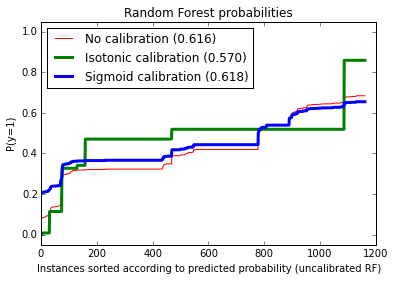

In [32]:
# Plot the data and the predicted probabilities
plt.figure()
order = np.lexsort((rf_probs, ))
plt.plot(rf_probs[order], 'r', label='No calibration (%1.3f)' % rf_score)
plt.plot(iso_rf_probs[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % iso_rf_score)
plt.plot(sig_rf_probs[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % sig_rf_score)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated RF)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Random Forest probabilities")

plt.show()